In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ir_measures import RR, R, nDCG, read_trec_run
import ir_datasets
import gzip
import json

In [72]:
from tqdm import tqdm
# qrels_dl19 = list(ir_datasets.load('msmarco-passage/trec-dl-2019').qrels)
# qrels_devs = list(ir_datasets.load('msmarco-passage/dev/small').qrels)
df = []
settings = []
for ncells in [1, 2, 4, 8]:
  for centroid_score_threshold in [0.3, 0.4, 0.45, 0.5, 0.6]:
    for ndocs in [256, 1024, 4096, 8192]:
        settings.append((
            f'plaid',
            f'plaid.ncells-{ncells}.cst-{centroid_score_threshold}.ndocs-{ndocs}',
            f'nprobe={ncells} tct={centroid_score_threshold} ndocs={ndocs}'
        ))
for n in [200, 500, 1000, 2000, 5000, 10000]:
    settings.append((
        f'rerank',
        f'ladr.num_results-{n}.num_neighbours-0.num_hops-0',
        f'n={n}'
    ))
for n in [100, 500, 1000]:
    for nn in [64, 128]:
        for d in [10,20,50]:
            settings.append((
                f'ladr',
                f'ladr.num_results-{n}.num_neighbours-{nn}.depth-{d}',
                f'n={n} neighbours={nn} depth={d}'
            ))
for cls, id, setting in tqdm(settings):
    latency = float(open(f'results/devs.{id}.time').read())
    res_dl19 = json.load(gzip.open(f'results/dl19.{id}.run.gz.measures.json.gz'))
    res_devs = json.load(gzip.open(f'results/devs.{id}.run.gz.measures.json.gz'))
    df.append({
        'class': cls,
        'setting': setting,
        'devs_latency': latency,
        'dl19_ndcg10': res_dl19['avg']['nDCG@10'],
        'dl19_ndcg1k': res_dl19['avg']['nDCG@1000'],
        'dl19_r1k': res_dl19['avg']['R(rel=2)@1000'],
        'dl19_rbo99': res_dl19['avg']['RBO(p=0.9)'],
        'devs_rr10': res_devs['avg']['RR@10'],
        'devs_r1k': res_devs['avg']['R@1000'],
        'devs_rbo99': res_devs['avg']['RBO(p=0.9)'],
    })
df = pd.DataFrame(df)
dl19_exh = json.load(gzip.open('results/dl19.exhuastive.run.gz.measures.json.gz'))['avg']
devs_exh = json.load(gzip.open('results/devs.exhuastive.run.gz.measures.json.gz'))['avg']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 100.09it/s]


In [73]:
def pareto(dataframe, x, y):
    dataframe = dataframe.sort_values(by=[x, y], ascending=[True, True])
    pareto_frontier = []
    for index, row in dataframe.iterrows():
        if not any(point[y] >= row[y] for point in pareto_frontier):
            pareto_frontier.append(row.copy())
    pareto_frontier = pd.DataFrame(pareto_frontier)
    return pareto_frontier

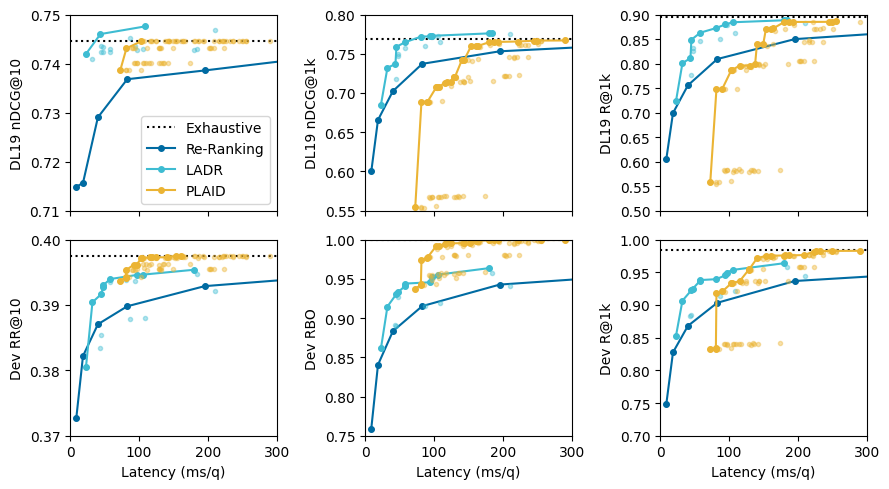

In [101]:
x='devs_latency'

fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharex='col', sharey=False)

for row, (ds, measures) in enumerate([('dl19', ['ndcg10', 'ndcg1k', 'r1k']), ('devs', ['rr10', 'rbo99', 'r1k'])]):
    for col, measure in enumerate(measures):
        y = f'{ds}_{measure}'
        ax = axs[row][col]
        exh = {
            'dl19_ndcg1k': dl19_exh['nDCG@1000'],
            'dl19_ndcg10': dl19_exh['nDCG@10'],
            'dl19_r1k': dl19_exh['R(rel=2)@1000'],
            'devs_rr10': devs_exh['RR@10'],
            'devs_r1k': devs_exh['R@1000'],
            'devs_rbo99': devs_exh['RBO(p=0.99)'],
        }[y]
        ax.axhline(exh, ls=':', c='k', label='Exhaustive')
        lines = {}
        for cls in ['rerank', 'ladr', 'plaid']:
            sub_df = df[df['class']==cls]
            c = {
                'ladr': '#3EBCD2',
                'rerank': '#006BA2',
                'plaid': '#EBB434',
            }[cls]
            line, = ax.plot(sub_df[x], sub_df[y], '.', alpha=0.4, c=c)
            p_df = pareto(sub_df.copy(), x=x, y=y)
            ax.plot(p_df[x], p_df[y], '.', c=line.get_color())
            label = {
                'plaid': 'PLAID',
                'rerank': 'Re-Ranking',
                'ladr': 'LADR',
            }[cls]
            line, = ax.plot(p_df[x], p_df[y], '-o', markersize=4, label=label, c=line.get_color())
            lines[cls] = line
        # sub_df = df[df.setting.isin(['nprobe=1 tct=0.5 ndocs=256', 'nprobe=2 tct=0.45 ndocs=1024', 'nprobe=4 tct=0.4 ndocs=4096'])]
        # rec, = ax.plot(sub_df[x], sub_df[y], '*', label='  paper', c='#FFD700')
        ax.set_xlim(0, 200)
        ax.set_xticks([0,100,200,300])
        if row == 1:
            ax.set_xlabel('Latency (ms/q)')
        ax.set_ylim({
                'dl19_ndcg10': (0.71, 0.75),
                'dl19_ndcg1k': (0.55, 0.80),
                'dl19_r1k': (0.5, 0.9),
                'devs_rr10': (0.37, 0.4),
                'devs_rbo99': (0.75, 1.0),
                'devs_r1k': (0.70, 1.0),
            }.get(y, (None, None)))
        if y == 'devs_rr10':
            ax.set_yticks([.37, .38, .39, .4])
        if y == 'dl19_r1k':
            ax.set_yticks([.5, .55, .6, .65, .7, .75, .8, .85, .9])
        ax.set_ylabel({
            'dl19_ndcg1k': 'DL19 nDCG@1k',
            'dl19_ndcg10': 'DL19 nDCG@10',
            'dl19_r1k': 'DL19 R@1k',
            'devs_rr10': 'Dev RR@10',
            'devs_rbo99': 'Dev RBO',
            'devs_r1k': 'Dev R@1k',
        }.get(y, y))
        # ax.legend(handles=[lines['plaid'], rec, lines['rerank'], lines['ladr']])
        if row == 0 and col == 0:
            ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('baselines.pdf')

In [104]:
df[df['class']=='rerank']

,class,setting,devs_latency,devs_rr,devs_r1k,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rr2,dl19_rr3
64,rerank,n=100,5.470599,0.358808,0.670893,0.701452,0.523258,0.497207,0.846899,0.507201
65,rerank,n=200,9.071591,0.372684,0.748114,0.714854,0.599939,0.604680,0.864341,0.530661
66,rerank,n=500,18.795654,0.382191,0.827495,0.715646,0.665553,0.699004,0.864341,0.523338
67,rerank,n=1000,40.418096,0.387050,0.867992,0.729022,0.702320,0.755495,0.864341,0.522016
68,rerank,n=2000,82.964285,0.389802,0.903343,0.736799,0.737109,0.809089,0.864341,0.545193
69,rerank,n=5000,195.281033,0.392881,0.936652,0.738586,0.753069,0.849768,0.864341,0.545139
70,rerank,n=10000,409.528575,0.394656,0.950334,0.742206,0.762571,0.869767,0.883721,0.547065


In [103]:
df[df['class']=='plaid'].sort_values('devs_latency')

,class,setting,devs_latency,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rbo99,devs_rr10,devs_r1k,devs_rbo99
16,plaid,nprobe=1 tct=0.6 ndocs=256,72.888170,0.738645,0.555195,0.558299,0.955053,0.393706,0.832056,0.937439
12,plaid,nprobe=1 tct=0.5 ndocs=256,80.508749,0.738645,0.553204,0.555261,0.957262,0.394180,0.833202,0.941875
4,plaid,nprobe=1 tct=0.4 ndocs=256,81.004532,0.738645,0.554370,0.557375,0.956779,0.394309,0.833560,0.943012
17,plaid,nprobe=1 tct=0.6 ndocs=1024,81.855051,0.743108,0.688715,0.748023,0.986434,0.395374,0.918887,0.973703
8,plaid,nprobe=1 tct=0.45 ndocs=256,85.272182,0.738645,0.553501,0.557375,0.956791,0.394291,0.833130,0.942637
...,...,...,...,...,...,...,...,...,...,...
71,plaid,nprobe=8 tct=0.45 ndocs=8192,249.633330,0.744548,0.766752,0.885540,0.999966,0.397450,0.982724,0.999357
43,plaid,nprobe=4 tct=0.3 ndocs=8192,250.615733,0.744548,0.761808,0.871215,0.999826,0.397497,0.982438,0.998848
79,plaid,nprobe=8 tct=0.6 ndocs=8192,255.148520,0.744548,0.765791,0.887649,0.999924,0.397395,0.981793,0.998124
67,plaid,nprobe=8 tct=0.4 ndocs=8192,255.885856,0.744548,0.766689,0.885772,0.999972,0.397450,0.982581,0.999441
